# Distributional Optimization with TrainSelPy

This notebook demonstrates the **distributional head** feature in TrainSelPy, which maintains a **distribution over solutions** rather than a single solution.

## Key Concept

Traditional optimization finds **one best solution**. Distributional optimization maintains a **weighted collection of solutions** (particles), enabling:
- **Robustness** to uncertainty
- **Risk management** through portfolio of solutions  
- **Diverse strategies** for different scenarios

## Use Case: Portfolio Selection Under Uncertainty

Instead of selecting ONE portfolio, maintain a DISTRIBUTION of portfolios weighted by their performance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from trainselpy.algorithms import initialize_population
from trainselpy.distributional_head import (
    ParticleDistribution,
    compress_top_k,
    compress_resampling,
    mutate_weights,
    mutate_support,
    crossover_particle_mixture
)
from trainselpy.operators import mutation

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)


## 1. Create Market Data

In [2]:
n_assets = 8
asset_returns = np.array([0.05, 0.08, 0.12, 0.07, 0.10, 0.06, 0.09, 0.11])
asset_risks = np.array([0.10, 0.15, 0.25, 0.12, 0.18, 0.08, 0.14, 0.20])

print("Asset Profiles:")
for i in range(n_assets):
    print(f"Asset {i+1}: Return={asset_returns[i]:.2f}, Risk={asset_risks[i]:.2f}")

Asset Profiles:
Asset 1: Return=0.05, Risk=0.10
Asset 2: Return=0.08, Risk=0.15
Asset 3: Return=0.12, Risk=0.25
Asset 4: Return=0.07, Risk=0.12
Asset 5: Return=0.10, Risk=0.18
Asset 6: Return=0.06, Risk=0.08
Asset 7: Return=0.09, Risk=0.14
Asset 8: Return=0.11, Risk=0.20


## 2. Create Initial Particle Distribution

First, generate a population of portfolio solutions, then create a distribution over them.

In [3]:
# Portfolio selection: choose 4 assets from 8
candidates = [list(range(n_assets))]
setsizes = [4]
settypes = ["UOS"]  # Unordered set

# Initialize population of portfolio solutions
population = initialize_population(candidates, setsizes, settypes, pop_size=20)

print(f"Created {len(population)} portfolio solutions")
print(f"\nExample portfolios:")
for i in range(3):
    selected = population[i].int_values[0]
    print(f"  Portfolio {i+1}: Assets {selected + 1}")

Created 20 portfolio solutions

Example portfolios:
  Portfolio 1: Assets [1 2 6 8]
  Portfolio 2: Assets [1 4 5 8]
  Portfolio 3: Assets [1 2 4 7]


## 3. Evaluate and Create Distribution

Assign weights to portfolios based on their performance.

In [4]:
# Evaluate each portfolio
fitness_scores = []
for sol in population:
    selected = sol.int_values[0]
    portfolio_return = np.mean(asset_returns[selected])
    portfolio_risk = np.mean(asset_risks[selected])
    
    # Sharpe-like ratio (return/risk)
    fitness = portfolio_return / (portfolio_risk + 0.01)
    fitness_scores.append(fitness)
    sol.fitness = fitness

# Create distribution: weight by fitness
fitness_array = np.array(fitness_scores)
weights = fitness_array / fitness_array.sum()

# Create ParticleDistribution
dist = ParticleDistribution(population, weights)

print(f"Particle Distribution:")
print(f"  Number of particles: {dist.K}")
print(f"  Weights sum: {dist.weights.sum():.4f}")
print(f"\nTop 3 weighted portfolios:")
top_indices = np.argsort(weights)[-3:][::-1]
for idx in top_indices:
    selected = population[idx].int_values[0]
    print(f"  Weight={weights[idx]:.3f}: Assets {selected + 1}")

Particle Distribution:
  Number of particles: 20
  Weights sum: 1.0000

Top 3 weighted portfolios:
  Weight=0.055: Assets [4 6 7 8]
  Weight=0.054: Assets [2 4 6 7]
  Weight=0.052: Assets [3 4 6 7]


## 4. Distributional Objectives

Different ways to evaluate a distribution of solutions:

In [5]:
from trainselpy.distributional_head import (
    mean_objective,
    mean_variance_objective,
    cvar_objective
)

# Extract fitness values
particle_fitness = np.array([p.fitness for p in dist.particles])

# Compute distributional objectives
mean_perf = mean_objective(dist, particle_fitness)
mean_var_perf = mean_variance_objective(dist, particle_fitness, lambda_var=0.5)
cvar_perf = cvar_objective(dist, particle_fitness, alpha=0.1)

print("Distributional Objective Values:")
print(f"  Mean Performance: {mean_perf:.4f}")
print(f"  Mean-Variance (λ=0.5): {mean_var_perf:.4f}")
print(f"  CVaR (α=0.1): {cvar_perf:.4f}")

print("\nInterpretation:")
print("  - Mean: Average fitness across distribution")
print("  - Mean-Variance: Balances performance and consistency")
print("  - CVaR: Focus on worst 10% of cases (tail risk)")

Distributional Objective Values:
  Mean Performance: 0.5203
  Mean-Variance (λ=0.5): 0.5206
  CVaR (α=0.1): 0.4864

Interpretation:
  - Mean: Average fitness across distribution
  - Mean-Variance: Balances performance and consistency
  - CVaR: Focus on worst 10% of cases (tail risk)


## 5. Compression Strategies

Reduce number of particles while preserving distribution quality.

Original distribution: 20 particles

Top-K (k=5): 5 particles
  Preserved weight: 1.0000

Resampling (k=5): 5 particles
  May have duplicates from resampling


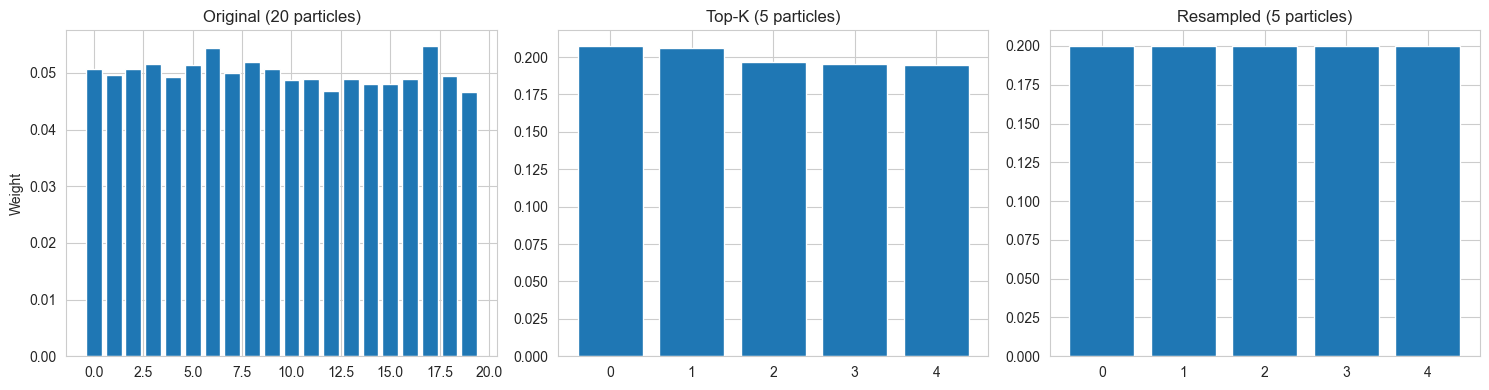

In [6]:
print(f"Original distribution: {dist.K} particles")

# Strategy 1: Keep top-k by weight
dist_topk = compress_top_k(dist, k=5)
print(f"\nTop-K (k=5): {dist_topk.K} particles")
print(f"  Preserved weight: {dist_topk.weights.sum():.4f}")

# Strategy 2: Resampling
dist_resample = compress_resampling(dist, k=5)
print(f"\nResampling (k=5): {dist_resample.K} particles")
print(f"  May have duplicates from resampling")

# Visualize weight distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(range(dist.K), dist.weights)
axes[0].set_title('Original (20 particles)')
axes[0].set_ylabel('Weight')

axes[1].bar(range(dist_topk.K), dist_topk.weights)
axes[1].set_title('Top-K (5 particles)')

axes[2].bar(range(dist_resample.K), dist_resample.weights)
axes[2].set_title('Resampled (5 particles)')

plt.tight_layout()
plt.show()

## 6. Distributional Operators

Mutation and crossover for distributions.

In [7]:
# Weight mutation: Perturb weights
dist_mut_weights = mutate_weights(dist, weight_intensity=0.1)

print("Weight Mutation:")
print(f"  Original weights: {dist.weights[:5]}")
print(f"  Mutated weights: {dist_mut_weights.weights[:5]}")

# Support mutation: Modify particles themselves
dist_mut_support = mutate_support(
    dist,
    base_mutate_fn=mutation,
    candidates=candidates,
    settypes=settypes,
    support_prob=0.3,
    mutintensity=0.2,
)

print("\nSupport Mutation (modifies particles):")
print(f"  Original particle 0: Assets {dist.particles[0].int_values[0] + 1}")
print(f"  Mutated particle 0: Assets {dist_mut_support.particles[0].int_values[0] + 1}")


Weight Mutation:
  Original weights: [0.05066326 0.04963417 0.05075538 0.05151954 0.04936421]
  Mutated weights: [0.04621213 0.04499353 0.04915246 0.0461715  0.04919197]

Support Mutation (modifies particles):
  Original particle 0: Assets [1 2 6 8]
  Mutated particle 0: Assets [1 2 3 6]


## 7. Crossover: Combine Distributions

In [8]:
# Create second distribution
pop2 = initialize_population(candidates, setsizes, settypes, pop_size=15)
for sol in pop2:
    selected = sol.int_values[0]
    sol.fitness = np.mean(asset_returns[selected]) / (np.mean(asset_risks[selected]) + 0.01)

fitness2 = np.array([s.fitness for s in pop2])
weights2 = fitness2 / fitness2.sum()
dist2 = ParticleDistribution(pop2, weights2)

# Crossover: Mix two distributions
offspring = crossover_particle_mixture(dist, dist2, alpha=0.5)

print(f"Crossover Results:")
print(f"  Parent 1: {dist.K} particles")
print(f"  Parent 2: {dist2.K} particles")
print(f"  Offspring: {offspring.K} particles")
print(f"\nOffspring combines particles from both parents")


Crossover Results:
  Parent 1: 20 particles
  Parent 2: 15 particles
  Offspring: 20 particles

Offspring combines particles from both parents


## 8. Practical Application: Asset Frequency Analysis

Which assets appear most frequently in the distribution?

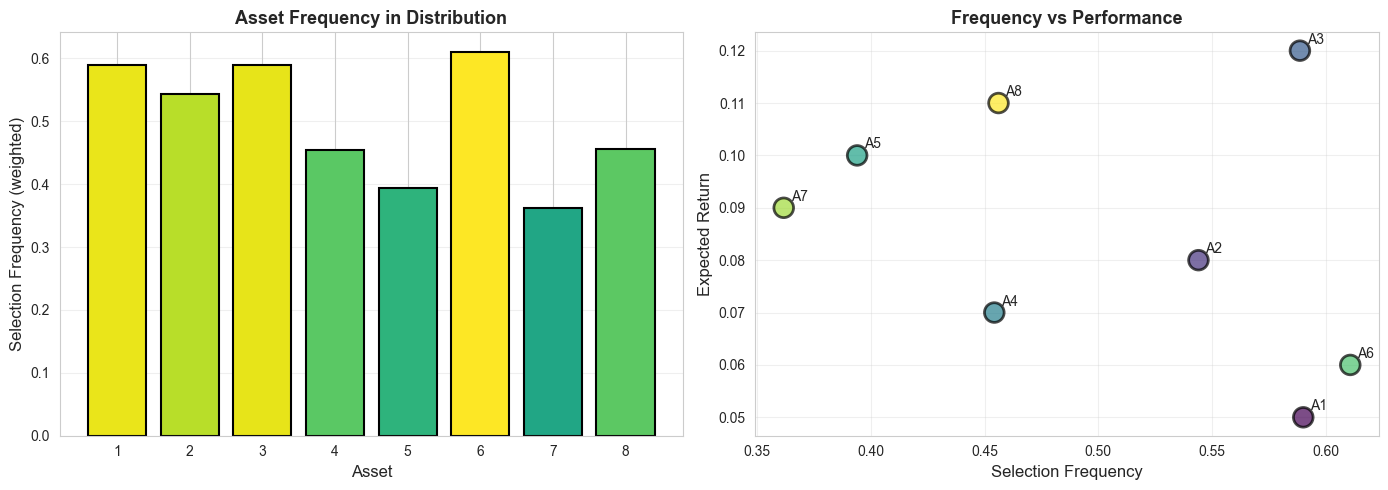


Interpretation:
  - High-frequency assets are robust choices
  - Appear often across different high-performing portfolios
  - Most selected: Asset 6 (0.61)


In [9]:
# Calculate weighted asset frequency
asset_freq = np.zeros(n_assets)
for particle, weight in zip(dist.particles, dist.weights):
    selected = particle.int_values[0]
    for asset in selected:
        asset_freq[asset] += weight

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Asset frequency
colors = plt.cm.viridis(asset_freq / asset_freq.max())
bars = ax1.bar(range(1, n_assets+1), asset_freq, color=colors, 
              edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Asset', fontsize=12)
ax1.set_ylabel('Selection Frequency (weighted)', fontsize=12)
ax1.set_title('Asset Frequency in Distribution', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Return vs frequency
ax2.scatter(asset_freq, asset_returns, s=200, c=range(n_assets), 
           cmap='viridis', edgecolors='black', linewidth=2, alpha=0.7)
for i in range(n_assets):
    ax2.annotate(f'A{i+1}', (asset_freq[i], asset_returns[i]), 
                xytext=(5, 5), textcoords='offset points')
ax2.set_xlabel('Selection Frequency', fontsize=12)
ax2.set_ylabel('Expected Return', fontsize=12)
ax2.set_title('Frequency vs Performance', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - High-frequency assets are robust choices")
print("  - Appear often across different high-performing portfolios")
print(f"  - Most selected: Asset {np.argmax(asset_freq) + 1} ({asset_freq.max():.2f})")

## Key Takeaways

### Distributional Optimization Benefits:

1. **Robustness**: Distribution hedges against uncertainty
2. **Flexibility**: Different particles for different scenarios
3. **Risk Management**: CVaR objective focuses on tail risk
4. **Interpretability**: Frequency indicates robustness

### When to Use:

- **High uncertainty** environments
- **Risk-averse** applications
- **Multiple scenarios** to handle
- Need **portfolio of strategies**

### Distributional Objectives:

- `mean`: Maximize average performance
- `mean_variance`: Balance performance and consistency
- `cvar`: Protect against worst cases